## Preprocessing Exercises

# Lesson 3: Pre-processing Part 1 - Global Thresholds

Fluorescence datasets ideally reflect a relationship between the pixels in an image and the location and local density of your fluorescent molecule in a sample. However, properties of the detectors, optics, or even the samples can confound direct interpretation of this data. Here we will present some operations that can mitigate these effects to achieve robust hypothesis testing. 

In this module, you will
- Review how to load digital images and associated metadata
- Understand what it means to find a threshold for an image
- Use a threshold to make a mask, i.e. separate the background and foreground of an image
- Learn how to use Otsu's method to find threshold values
- Understand the mechanics of Otsu's method, and learn its limitations

#### First, a note about Jupyter notebooks for preprocessing pipelines:  

They are great for the type of quick data visualization that you might want when developing an analysis pipeline. However, it's hard to build on notebooks or use functionalities in them between projects. For this reason, you may want to consider moving your most useful functions into scripts and working that way when looping through many types of data.  

That said, few things as transparently demonstrate an analysis workflow, and they make wonderful supplements to the Materials sections of papers.  
See http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261   
https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks   
notable example: http://nbviewer.jupyter.org/github/WagnerLabPapers/Waskom_JNeurosci_2014/blob/master/Behavioral_and_Decoding_Analyses.ipynb

### Today's project

We will work with fluorescence microscopy data to characterize how vinculin contributes to cell spreading and focal adhesion formation. 

The signals that we will be looking at are phalloidin (F-actin), paxillin-EGFP (focal adhesion protein), and Heochst (nuclei). 

Hypothesis:
 - Preprocessing Part 1: Vinculin promotes cell spreading. The vinculin-null cells will have a spreading defect.
 - Preprocessing Part 2: Vinculin promotes focal adhesion formation. Vinculin-null cells will have fewer focal adhesions, smaller focal adhesions, or less focal total focal adhesion area.

Notebook settings and libraries: 

In [4]:
%matplotlib inline
     #keeps the plots that you display within the notebook

#run me to import the libraries that you'll need for this exercise
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
sns.set_style('dark', rc={'image.cmap':'inferno'})
import matplotlib.axes as ax
import scipy.ndimage

sns.set_style('dark', rc={'image.cmap':'inferno'}) #this sets the default heatmap of images in "imshow" as the inferno heatmap (no more jet!))

Define your data directory to make loading and saving data later more robust

In [ ]:
pwd

In [ ]:
data_path = 'insert path to data directory here'

In [ ]:
import os
os.listdir(data_path)

### Exercise: Load the WT and vincKO images into memory and report the dimensions of the data.

In [9]:
#run me to load data needed for the exercise
from skimage.io import imread #import the imread function

wt_filename = data_path + "20170601-WT-DMSO-1.tif"
wt_data = imread(wt_filename)

vinc_filename = data_path + "20170601-vincKO-DMSO-1.tif"
vinc_data = imread(vinc_filename)

NameError: name 'data_path' is not defined

Load the metadata:   
Here I have saved the metadata in a file format called json. Json files are easily loaded into python as the dictionary data type. Dictionaries in python are indexed with keys, which are strings instead of numerical indices (such as used in lists). To understand this concept, load the below json file and examine it.

In [5]:
#run me to import the metadata
import json
with open(data_path + "20170601-vincKO-DMSO-1.json", mode='r') as metadata_wt:
    meta_wt = json.load(metadata_wt)

NameError: name 'data_path' is not defined

In [7]:
#look at the contents of meta_wt


It can be useful to organize your data into a dict instead of a numerical array when one of the dimensions of the array corresponds to something that is non-numerical in nature. Here, the channel dimension is stored as another dimension in the numerical array that is wt_data. To get the image corresponding to one of the channels, you would have to remember which of the channel slices corresponds to the channel you would like to see. Below we'll organize the data into a dict so that the channels can be indexed by an intuitive string and not a numerical index. 

In [ ]:
#run me to organize the data into a dictionary, where the channels can be indexed with a string  
wt = {}
vinc = {}

for idx, channel in enumerate(meta_wt['channels']):
    wt[channel] = wt_data[:,:,idx]
    vinc[channel] = vinc_data[:,:,idx] #add in the indexing when read in full dataset
    print(channel)

### Exercise: Set the wild type actin slice to the variable "data"

In [10]:
data = 

SyntaxError: invalid syntax (<ipython-input-10-af9df1cded08>, line 1)

Display the images to make sure everything worked as expected...

NameError: name 'wt' is not defined

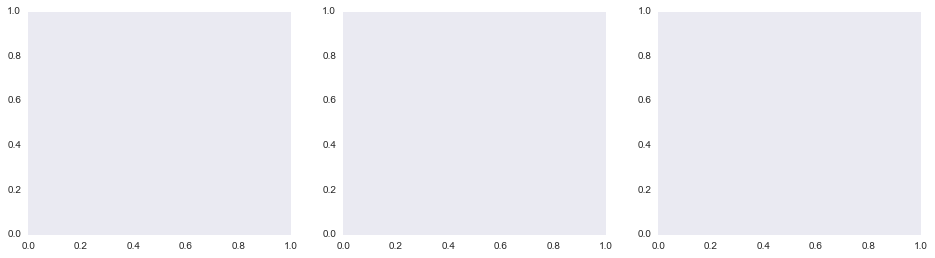

In [13]:
#visualize all data simultaneously
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(wt["actin"])
ax[1].imshow(wt['nucleus'])
ax[2].imshow(wt["pax"])

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(vinc["actin"])
ax[1].imshow(vinc['nucleus'])
ax[2].imshow(vinc["pax"])

### Exercise: Use imshow to zoom in on a small section of the pax images to examine the small structures.

## Image pre-processing: a motivating example

Today, we will define the ROIs in the image. We'll find that the quality of masks can be improved by preprocessing the images by quantitatively determining thresholds and filtering to remove noise. We will then cover how to clean up the mask and turn it into an accurate ROI using morphological image processing. 

**Preprocessing misteps are a good way to get a paper retracted. We argue that it's easier to make these misteps when doing things manually, but it's not *impossible* to do it computationally. In fact if you don't check intermediate steps of your data in either case, it's no good. Always visualize your intermediates!**

### Exercise: write a function that has the following attributes: 
- Input: numerical threshold and input image
- Output: visualization of the the images binary mask

### Exercise: Determine a global threshold for the nucleus channel of both images. Discuss what is preventing this from working robustly.

In [ ]:
data1 = vinc["actin"]
data2 = wt["actin"]

from ipywidgets import interactive
@interactive
def show_masks(thresh=(0, data1.max() * 0.3, 40)):
    fig, ax = plt.subplots(1, 2, figsize=(64, 16))
    mask1 = np.zeros(data1.shape)
    mask2 = np.zeros(data2.shape)
    
    mask1[data1 >=thresh] = 1
    mask2[data2 >=thresh] = 1
    
    ax[0].imshow(mask1, vmin=0, vmax=1)
    ax[1].imshow(mask2, vmin=0, vmax=1)
show_masks

Today, we will define the ROIs in this set of images. You may have noticed some qualities of the above images that make them hard to reliably threshold into masks relecting the relevant cell organelles.

Addressed in Preprocessing part 1:
1. There appears to be some variation in the background and intensity between actin datasets. Perhaps there was some variability in the focus when the image was taken, someone opened the microscope room door during imaging of one of the datasets, pipetting error when staining, or that some of the cells really do have more actin. 
    - automated statistical thresholding methods
    
Addressed preprocessing part 2:
2. Noise corrupting the images
    - Introduction to Rank Filters: median filter
2. Uneven illumination in the nucleus channel makes finding a single threshold across a single image challenging. 
    - Rolling ball background subtraction
3. Uneven paxillin expression, low EGFP signal, and cytoplasmic signal complicate focal adhesion thresholding
    - thresholding within defined ROIs
    
Addressed in Morphological Operations:
4. Small blobs appear in nuclear mask, making it hard to count nuclei

### Exercise: View the histogram of pixel values for the nucleus dataset. Does Otsu's method make sense? Perform Otsu's thresholding on the nucleus dataset.

In [17]:
#you can use seaborn's distplot with fewer arguments than I used. This can be a one-line exercise
#you may need to use the "flatten" function.
#if you are stumped, look up the documentation on both.






### Exercise: Determine what is incorrect about the application of Otsu's method below (there are two independent errors)

In [ ]:
from skimage import filters
thresh = filters.threshold_li(data)
print("the Otsu masking threshold for this dataset is:", thresh)

mask = np.zeros(data.shape)
mask[data <=thresh] = 1

plt.imshow(mask_zoom_edge, vmin=0, vmax=1)

### Exercise: Otsu's method performs sub-optimally in this case because of the distribution of background and foreground values. 
Find the documentation for the scipy filter options and determine if another thresholding algorithm would be more appropriate. 

In [ ]:
wt_masks = {}
vinc_masks = {}

for ch in wt:
    wt_masks[ch] = mask_im(wt[ch], filters.threshold_otsu(wt[ch]))
    vinc_masks[ch] = mask_im(vinc[ch], filters.threshold_otsu(vinc[ch]))

# Preprocessing 2: Rank filters